# Task 1: Sentiment Analysis on Product Reviews

## Overview
This notebook implements a comprehensive sentiment analysis system for product reviews using classical machine learning approaches. We'll build a binary classifier to determine positive/negative sentiment in text reviews using the **real IMDb movie reviews dataset**.

## Learning Objectives
- Master text preprocessing techniques from Lab 1
- Apply word representation methods from Lab 2 (TF-IDF, CountVectorizer)
- Build and compare multiple classification models
- Visualize results and most important features

## Dataset
We'll use the real IMDb movie reviews dataset (50,000 reviews) labeled as positive or negative.

## Pipeline Overview
1. **Data Loading & Exploration**
2. **Text Preprocessing** (cleaning, tokenization, stopword removal)
3. **Feature Extraction** (TF-IDF and Count Vectorization)
4. **Model Training** (Logistic Regression, Naive Bayes, SVM)
5. **Model Evaluation & Comparison**
6. **Feature Analysis & Visualization**


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Import our custom utilities
import sys
sys.path.append('./utils')
from preprocessing import TextPreprocessor
from evaluation import evaluate_classification, plot_roc_curve, compare_models

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\assem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Data Loading and Exploration

We'll load the real IMDb dataset and explore its structure and characteristics.


In [ ]:
# Load the real IMDb dataset
print("Loading IMDb Dataset...")

# Load the CSV file directly from the project directory
df = pd.read_csv('../IMDB Dataset.csv')

print("Successfully loaded real IMDb dataset!")

# Convert sentiment labels to numeric (positive=1, negative=0)
if df['sentiment'].dtype == 'object':
    sentiment_map = {'positive': 1, 'negative': 0}
    df['sentiment'] = df['sentiment'].map(sentiment_map)

# Shuffle the dataset
np.random.seed(42)
df = df.sample(frac=1).reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts())

# Basic statistics
print(f"\nBasic text statistics:")
df['review_length'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().str.len()

print(f"Average review length: {df['review_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")
print(f"Max review length: {df['review_length'].max()} characters")
print(f"Min review length: {df['review_length'].min()} characters")

print(f"\nSample positive review:")
positive_sample = df[df['sentiment'] == 1]['review'].iloc[0]
print(f"'{positive_sample[:300]}...'")

print(f"\nSample negative review:")
negative_sample = df[df['sentiment'] == 0]['review'].iloc[0]
print(f"'{negative_sample[:300]}...'")


Loading IMDb Dataset...
✅ Successfully loaded real IMDb dataset!
Dataset shape: (50000, 2)
Columns: ['review', 'sentiment']

First few rows:
                                              review  sentiment
0  I really liked this Summerslam due to the look...          1
1  Not many television shows appeal to quite as m...          1
2  The film quickly gets to a major chase scene w...          0
3  Jane Austen would definitely approve of this o...          1
4  Expectations were somewhat high for me when I ...          0

Sentiment distribution:
sentiment
1    25000
0    25000
Name: count, dtype: int64

Basic text statistics:
Average review length: 1309.43 characters
Average word count: 231.16 words
Max review length: 13704 characters
Min review length: 32 characters

Sample positive review:
'I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's 

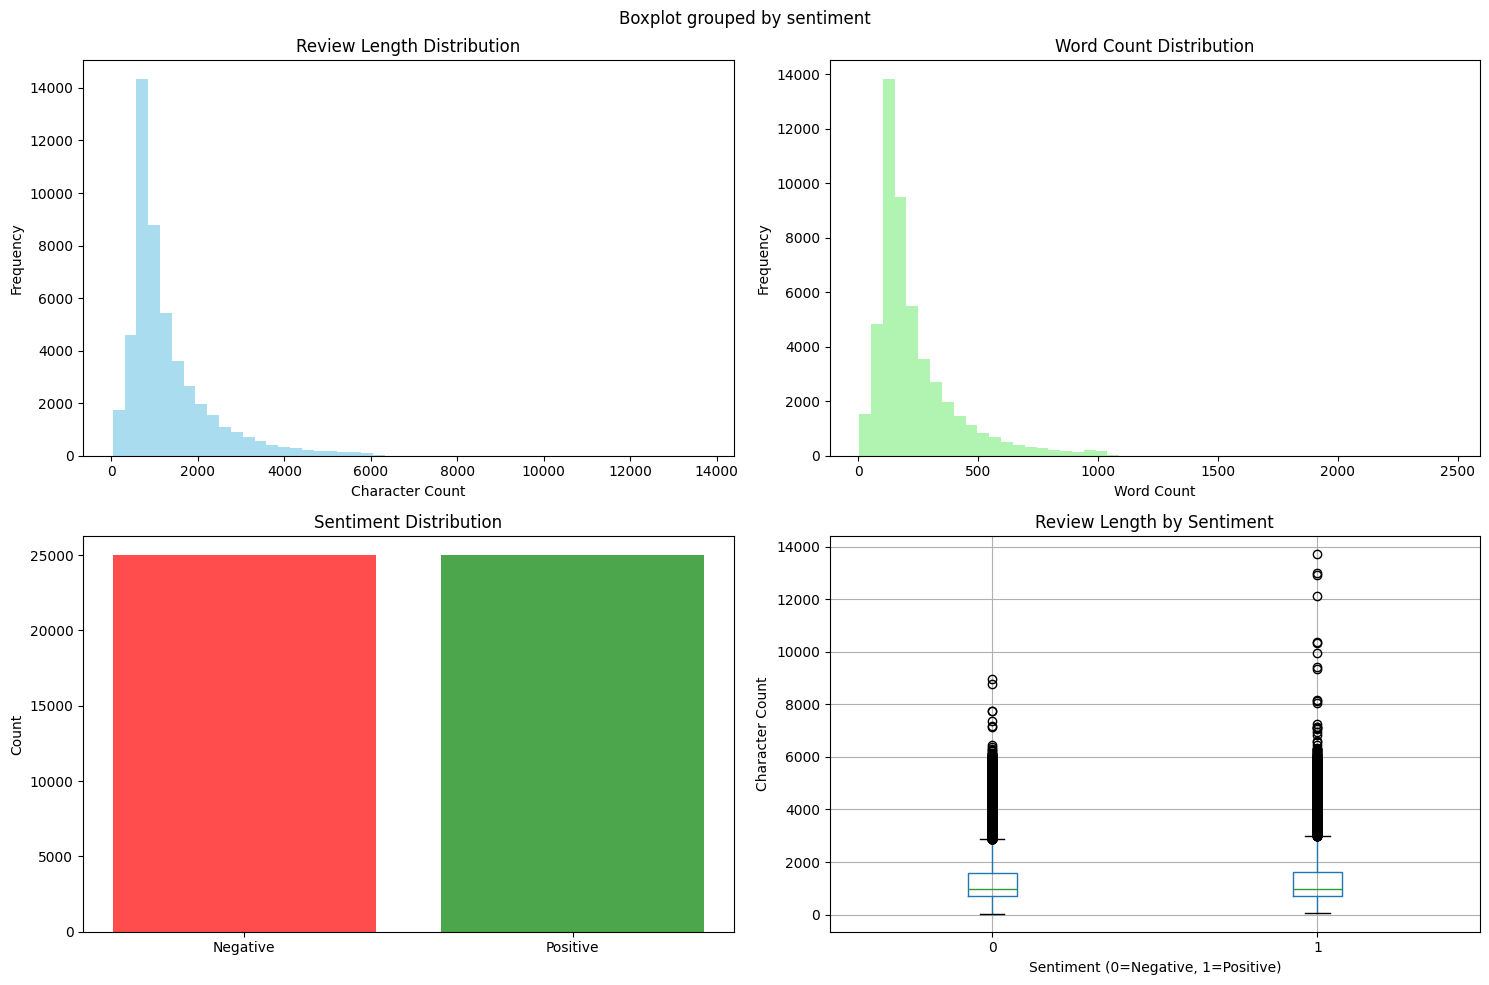

Class distribution:
Positive: 25000 (50.0%)
Negative: 25000 (50.0%)


In [3]:
# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Review length distribution
axes[0, 0].hist(df['review_length'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Review Length Distribution')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')

# Word count distribution
axes[0, 1].hist(df['word_count'], bins=50, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Word Count Distribution')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')

# Sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
axes[1, 0].bar(['Negative', 'Positive'], sentiment_counts.values, color=['red', 'green'], alpha=0.7)
axes[1, 0].set_title('Sentiment Distribution')
axes[1, 0].set_ylabel('Count')

# Review length by sentiment
df.boxplot(column='review_length', by='sentiment', ax=axes[1, 1])
axes[1, 1].set_title('Review Length by Sentiment')
axes[1, 1].set_xlabel('Sentiment (0=Negative, 1=Positive)')
axes[1, 1].set_ylabel('Character Count')

plt.tight_layout()
plt.show()

print(f"Class distribution:")
print(f"Positive: {sentiment_counts[1]} ({sentiment_counts[1]/len(df)*100:.1f}%)")
print(f"Negative: {sentiment_counts[0]} ({sentiment_counts[0]/len(df)*100:.1f}%)")


## 2. Text Preprocessing

We'll apply comprehensive text preprocessing using techniques from Lab 1.


In [4]:
# Initialize text preprocessor
preprocessor = TextPreprocessor(
    remove_html=True,
    expand_contractions=True,
    to_lowercase=True,
    remove_punctuation=True,
    remove_numbers=True,
    remove_stopwords=True,
    lemmatize=True,
    min_length=2
)

print("Original text example:")
original_text = df['review'].iloc[0]
print(f"'{original_text[:300]}...'")

# Apply preprocessing to a sample first
processed_sample = preprocessor.preprocess_text(original_text)
print("\nProcessed text example:")
print(f"'{processed_sample[:300]}...'")

print(f"\nText reduction: {len(original_text)} -> {len(processed_sample)} characters ({((len(original_text) - len(processed_sample))/len(original_text)*100):.1f}% reduction)")


Original text example:
'I really liked this Summerslam due to the look of the arena, the curtains and just the look overall was interesting to me for some reason. Anyways, this could have been one of the best Summerslam's ever if the WWF didn't have Lex Luger in the main event against Yokozuna, now for it's time it was ok ...'

Processed text example:
'really liked summerslam due look arena curtain look overall interesting reason anyways could one best summerslam ever wwf lex luger main event yokozuna time ok huge fat man strong man glad time changed terrible main event like every match luger terrible match card razor ramon ted dibiase steiner bro...'

Text reduction: 1107 -> 717 characters (35.2% reduction)


In [ ]:
# Apply preprocessing to the entire dataset
# For demonstration, let's work with a subset (10,000 reviews) for faster processing
# You can change sample_size to use the full dataset
sample_size = 10000
print(f"Working with {sample_size} reviews for faster processing...")

# Sample the dataset
df_sample = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
print(f"Sample class distribution: {df_sample['sentiment'].value_counts()}")

print("Applying text preprocessing to the dataset...")
print("This may take a few minutes...")

# Apply preprocessing
df_sample['processed_review'] = df_sample['review'].apply(preprocessor.preprocess_text)

print("Preprocessing completed!")

# Compare text lengths before and after preprocessing
print("\nText length comparison:")
original_lengths = df_sample['review'].str.len()
processed_lengths = df_sample['processed_review'].str.len()

print(f"Original - Mean: {original_lengths.mean():.1f}, Median: {original_lengths.median():.1f}")
print(f"Processed - Mean: {processed_lengths.mean():.1f}, Median: {processed_lengths.median():.1f}")
print(f"Reduction: {((original_lengths.mean() - processed_lengths.mean()) / original_lengths.mean() * 100):.1f}%")


Working with 10000 reviews for faster processing...
Sample class distribution: sentiment
1    5049
0    4951
Name: count, dtype: int64
Applying text preprocessing to the dataset...
This may take a few minutes...
✅ Preprocessing completed!

Text length comparison:
Original - Mean: 1313.7, Median: 973.5
Processed - Mean: 802.5, Median: 587.0
Reduction: 38.9%


Creating word clouds for positive and negative sentiments...


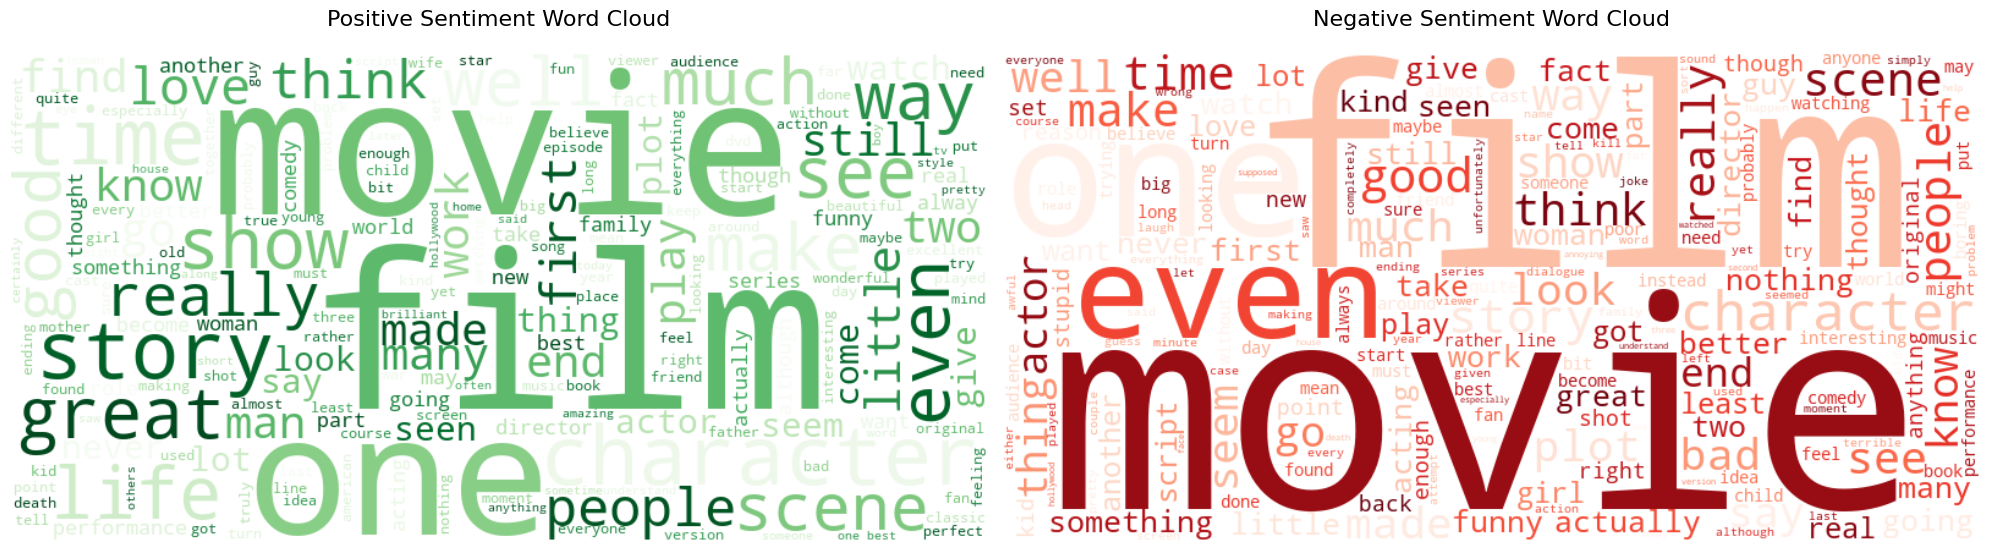

In [6]:
# Create word clouds for different sentiments
print("Creating word clouds for positive and negative sentiments...")

# Separate positive and negative reviews
positive_text = ' '.join(df_sample[df_sample['sentiment'] == 1]['processed_review'].tolist())
negative_text = ' '.join(df_sample[df_sample['sentiment'] == 0]['processed_review'].tolist())

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Positive sentiment word cloud
wordcloud_pos = WordCloud(width=800, height=400, background_color='white', 
                         colormap='Greens').generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Positive Sentiment Word Cloud', fontsize=16, pad=20)

# Negative sentiment word cloud
wordcloud_neg = WordCloud(width=800, height=400, background_color='white', 
                         colormap='Reds').generate(negative_text)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Negative Sentiment Word Cloud', fontsize=16, pad=20)

plt.tight_layout()
plt.show()


## 3. Feature Extraction

We'll use both TF-IDF and Count Vectorization to convert text to numerical features (from Lab 2 concepts).


In [7]:
# Prepare data for modeling
X = df_sample['processed_review']
y = df_sample['sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training set class distribution:")
print(y_train.value_counts())

# Initialize vectorizers
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Limit to top 5000 features
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95  # Ignore terms that appear in more than 95% of documents
)

count_vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# Fit and transform training data
print("\nFitting TF-IDF vectorizer...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Fitting Count vectorizer...")
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

print(f"\nTF-IDF feature matrix shape: {X_train_tfidf.shape}")
print(f"Count feature matrix shape: {X_train_count.shape}")

# Show some feature names
print(f"\nSample TF-IDF features:")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(feature_names[:20])


Training set size: 8000
Test set size: 2000
Training set class distribution:
sentiment
1    4039
0    3961
Name: count, dtype: int64

Fitting TF-IDF vectorizer...
Fitting Count vectorizer...

TF-IDF feature matrix shape: (8000, 5000)
Count feature matrix shape: (8000, 5000)

Sample TF-IDF features:
['abandoned' 'ability' 'able' 'absence' 'absent' 'absolute' 'absolutely'
 'absolutely nothing' 'absurd' 'abuse' 'abused' 'academy' 'academy award'
 'accent' 'accept' 'acceptable' 'accepted' 'access' 'accident'
 'accidentally']


## 4. Model Training and Evaluation

We'll train multiple models and compare their performance.


In [8]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(random_state=42, probability=True, C=1.0, kernel='linear'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Train and evaluate models with TF-IDF features
print("Training models with TF-IDF features:")
print("="*50)

tfidf_results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    model.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Evaluate
    results = evaluate_classification(
        y_test, y_pred, y_pred_proba, 
        labels=['Negative', 'Positive'], 
        plot=False
    )
    
    tfidf_results[name] = {
        'model': model,
        'results': results
    }
    
    # Print results
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall: {results['recall']:.4f}")
    print(f"  F1-Score: {results['f1_score']:.4f}")
    if results['roc_auc'] is not None:
        print(f"  ROC-AUC: {results['roc_auc']:.4f}")


Training models with TF-IDF features:

Training Logistic Regression...
  Accuracy: 0.8760
  Precision: 0.8615
  Recall: 0.8990
  F1-Score: 0.8798
  ROC-AUC: 0.9485

Training Naive Bayes...
  Accuracy: 0.8630
  Precision: 0.8601
  Recall: 0.8703
  F1-Score: 0.8652
  ROC-AUC: 0.9410

Training SVM...
  Accuracy: 0.8675
  Precision: 0.8558
  Recall: 0.8871
  F1-Score: 0.8712
  ROC-AUC: 0.9465

Training Random Forest...
  Accuracy: 0.8435
  Precision: 0.8517
  Recall: 0.8356
  F1-Score: 0.8436
  ROC-AUC: 0.9203



MODEL COMPARISON SUMMARY

Model Performance Comparison:
                          Model  Accuracy  Precision  Recall  F1-Score  \
0  Logistic Regression (TF-IDF)    0.8760     0.8615  0.8990    0.8798   
1          Naive Bayes (TF-IDF)    0.8630     0.8601  0.8703    0.8652   
2                  SVM (TF-IDF)    0.8675     0.8558  0.8871    0.8712   
3        Random Forest (TF-IDF)    0.8435     0.8517  0.8356    0.8436   

   ROC-AUC  
0   0.9485  
1   0.9410  
2   0.9465  
3   0.9203  

🏆 Best performing model: Logistic Regression (TF-IDF) (F1-Score: 0.8798)


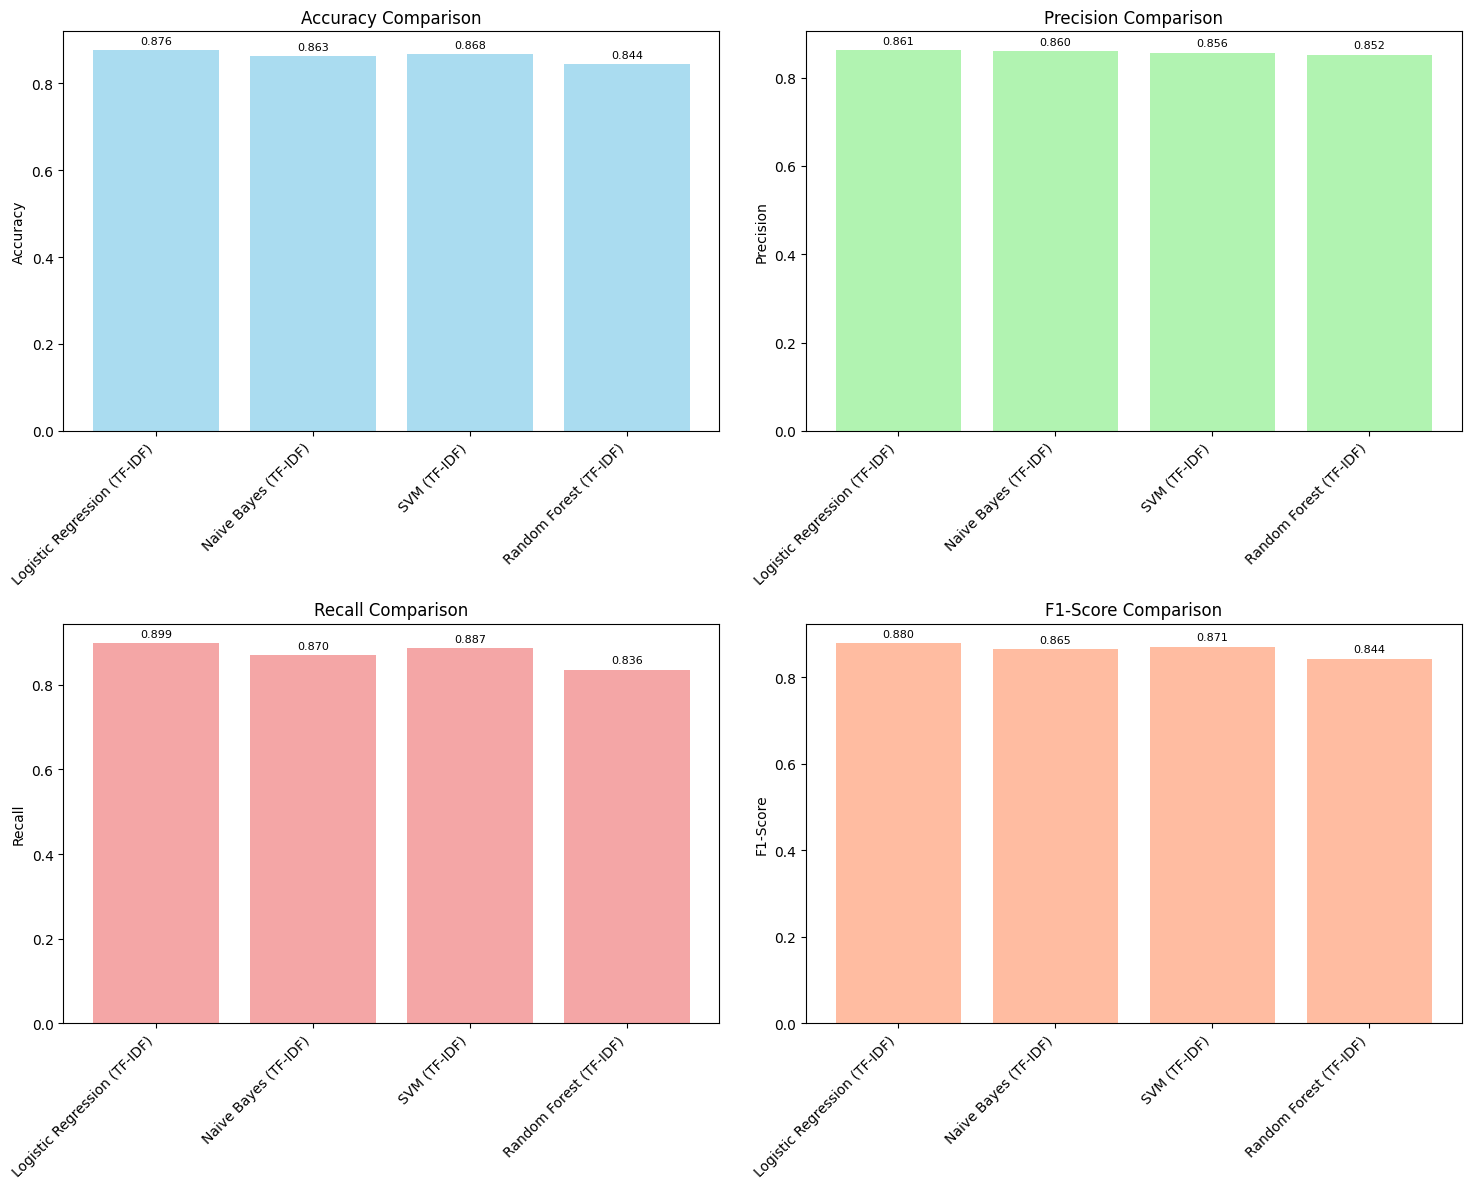

In [ ]:
# Compare all models and visualize results
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

# Create comparison dataframe
comparison_data = []

for name in models.keys():
    tfidf_res = tfidf_results[name]['results']
    
    comparison_data.append({
        'Model': f'{name} (TF-IDF)',
        'Accuracy': tfidf_res['accuracy'],
        'Precision': tfidf_res['precision'],
        'Recall': tfidf_res['recall'],
        'F1-Score': tfidf_res['f1_score'],
        'ROC-AUC': tfidf_res['roc_auc'] if tfidf_res['roc_auc'] is not None else 0
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
print(comparison_df.round(4))

# Find best model
best_idx = comparison_df['F1-Score'].idxmax()
best_model_name = comparison_df.loc[best_idx, 'Model']
print(f"\nBest performing model: {best_model_name} (F1-Score: {comparison_df.loc[best_idx, 'F1-Score']:.4f})")

# Plot model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    
    x_pos = np.arange(len(comparison_df))
    bars = ax.bar(x_pos, comparison_df[metric], color=colors[i], alpha=0.7)
    
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    
    # Add value labels on bars
    for bar, value in zip(bars, comparison_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


## 5. Feature Analysis and Visualization

Let's analyze which features (words) are most important for sentiment classification.


In [10]:
# Feature importance analysis using the best performing model
# Let's use Logistic Regression with TF-IDF for feature analysis
best_model = tfidf_results['Logistic Regression']['model']
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get feature coefficients
coefficients = best_model.coef_[0]

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("Top 20 most important features for sentiment classification:")
print(feature_importance_df.head(20))

# Separate positive and negative sentiment features
positive_features = feature_importance_df[feature_importance_df['coefficient'] > 0].head(15)
negative_features = feature_importance_df[feature_importance_df['coefficient'] < 0].head(15)

print(f"\nTop 15 features for POSITIVE sentiment:")
for idx, row in positive_features.iterrows():
    print(f"{row['feature']}: {row['coefficient']:.3f}")

print(f"\nTop 15 features for NEGATIVE sentiment:")
for idx, row in negative_features.iterrows():
    print(f"{row['feature']}: {row['coefficient']:.3f}")


Top 20 most important features for sentiment classification:
        feature  coefficient  abs_coefficient
4917      worst    -5.821747         5.821747
301         bad    -5.760018         5.760018
1890      great     4.595408         4.595408
1391  excellent     3.998708         3.998708
465      boring    -3.985868         3.985868
4395   terrible    -3.942819         3.942819
4784      waste    -3.794260         3.794260
290       awful    -3.620601         3.620601
3038    nothing    -3.510410         3.510410
386        best     3.340639         3.340639
3352       poor    -3.227444         3.227444
3860     script    -2.963133         2.963133
2563       love     2.900513         2.900513
3252    perfect     2.852114         2.852114
1508   favorite     2.851599         2.851599
2773     minute    -2.830734         2.830734
4250     stupid    -2.732429         2.732429
1356       even    -2.728845         2.728845
147     amazing     2.695827         2.695827
4825       well    

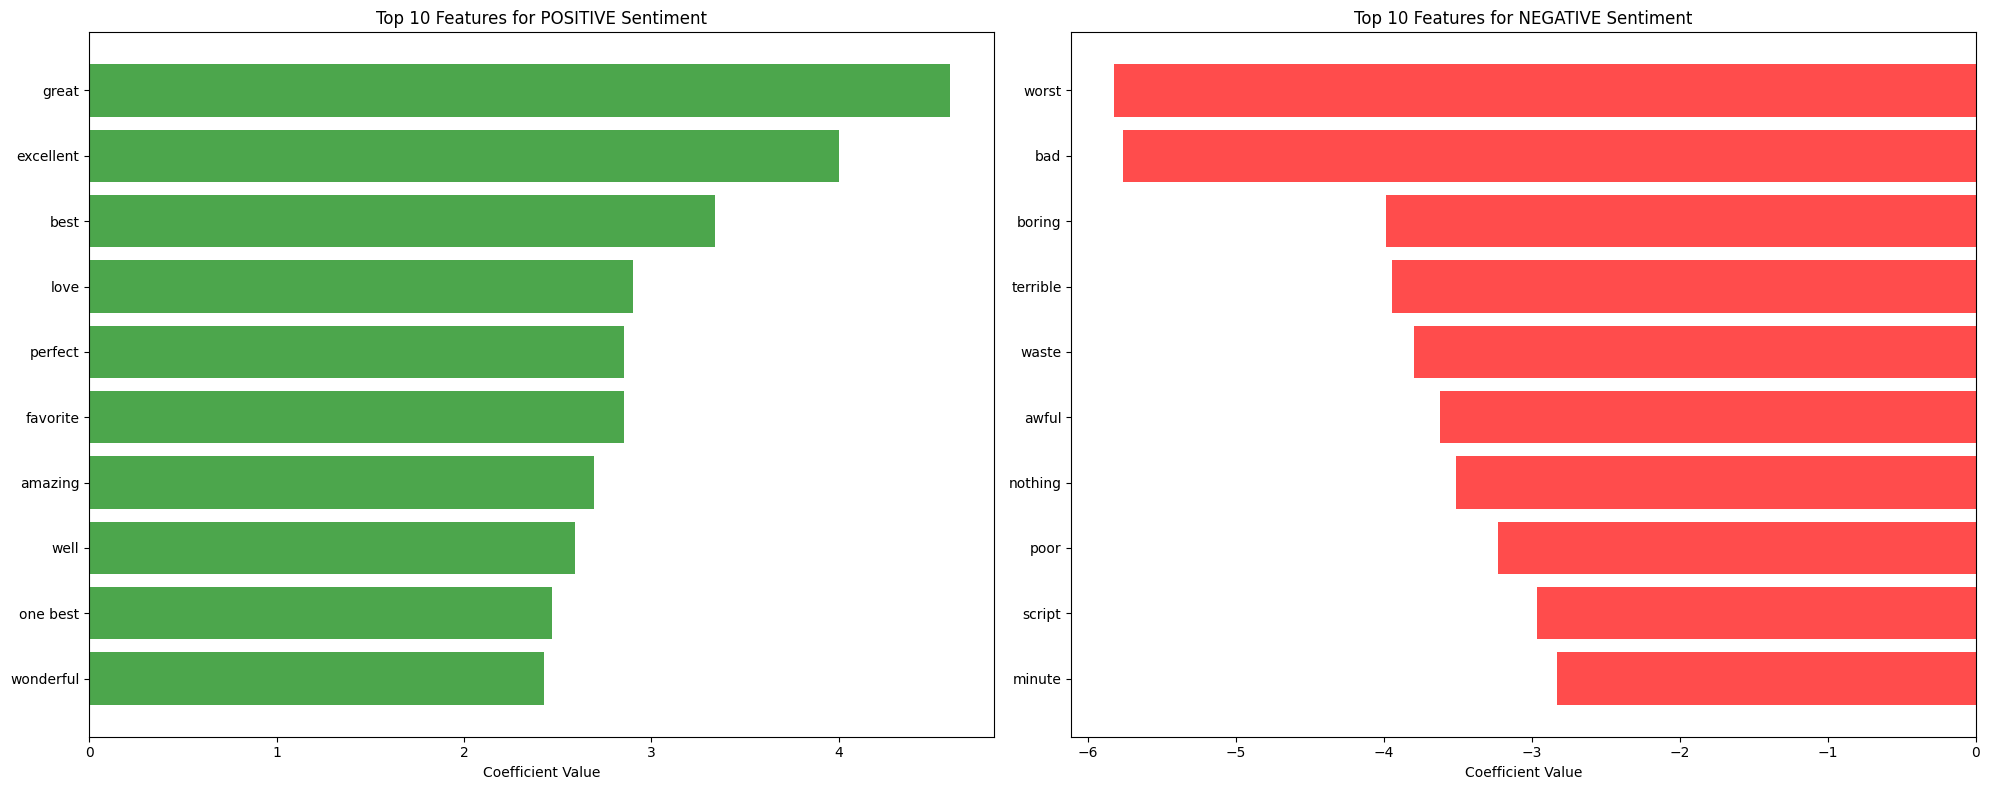


Creating word clouds for most important sentiment words...


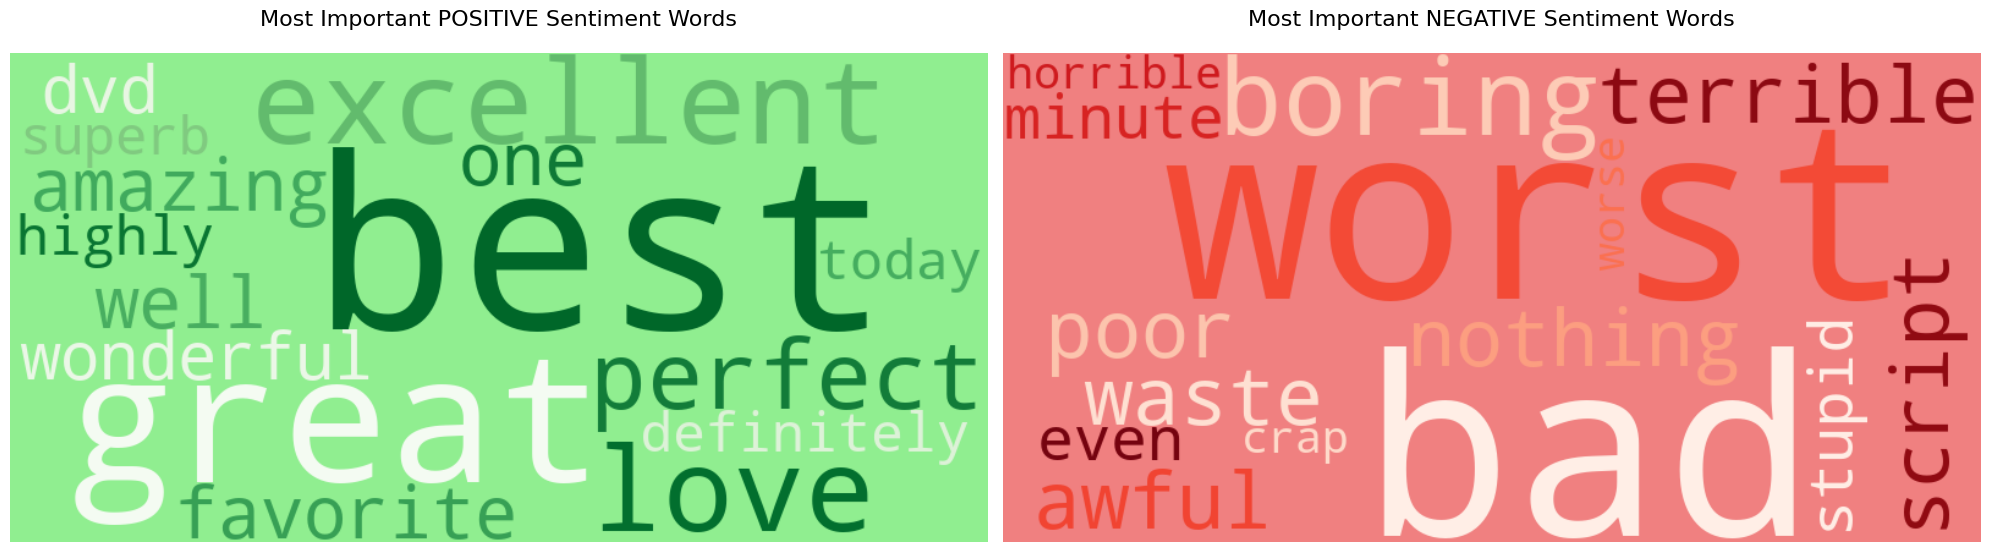

In [11]:
# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Positive features
pos_features = positive_features.head(10)
ax1.barh(range(len(pos_features)), pos_features['coefficient'], color='green', alpha=0.7)
ax1.set_yticks(range(len(pos_features)))
ax1.set_yticklabels(pos_features['feature'])
ax1.set_xlabel('Coefficient Value')
ax1.set_title('Top 10 Features for POSITIVE Sentiment')
ax1.invert_yaxis()

# Negative features
neg_features = negative_features.head(10)
ax2.barh(range(len(neg_features)), neg_features['coefficient'], color='red', alpha=0.7)
ax2.set_yticks(range(len(neg_features)))
ax2.set_yticklabels(neg_features['feature'])
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Top 10 Features for NEGATIVE Sentiment')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Create word clouds for most important positive and negative words
print("\nCreating word clouds for most important sentiment words...")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Positive words word cloud
positive_words = ' '.join(positive_features['feature'].tolist())
wordcloud_pos = WordCloud(width=800, height=400, background_color='lightgreen', 
                         colormap='Greens').generate(positive_words)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Most Important POSITIVE Sentiment Words', fontsize=16, pad=20)

# Negative words word cloud
negative_words = ' '.join(negative_features['feature'].tolist())
wordcloud_neg = WordCloud(width=800, height=400, background_color='lightcoral', 
                         colormap='Reds').generate(negative_words)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Most Important NEGATIVE Sentiment Words', fontsize=16, pad=20)

plt.tight_layout()
plt.show()


## 6. Model Testing and Prediction

Let's test our best model on some new examples and create a simple prediction function.


In [12]:
# Create a prediction function
def predict_sentiment(text, model=best_model, vectorizer=tfidf_vectorizer, preprocessor=preprocessor):
    """
    Predict sentiment for a given text
    
    Args:
        text: Input text string
        model: Trained classification model
        vectorizer: Fitted vectorizer
        preprocessor: Text preprocessor
    
    Returns:
        Dict with prediction and confidence
    """
    # Preprocess text
    processed_text = preprocessor.preprocess_text(text)
    
    # Vectorize
    text_vector = vectorizer.transform([processed_text])
    
    # Predict
    prediction = model.predict(text_vector)[0]
    probability = model.predict_proba(text_vector)[0]
    
    sentiment = 'positive' if prediction == 1 else 'negative'
    confidence = max(probability)
    
    return {
        'text': text,
        'processed_text': processed_text,
        'sentiment': sentiment,
        'confidence': confidence,
        'probabilities': {
            'negative': probability[0],
            'positive': probability[1]
        }
    }

# Test with some example texts
test_texts = [
    "This movie is absolutely amazing! I loved every minute of it.",
    "Terrible film. Worst movie I've ever seen. Complete waste of time.",
    "The movie was okay, nothing special but not bad either.",
    "Outstanding performance by the actors. Brilliant storyline!",
    "Boring and predictable. I fell asleep halfway through.",
    "Great cinematography and excellent direction. Highly recommended!",
    "Poor script and awful acting. Very disappointing.",
    "An incredible masterpiece! One of the best films ever made.",
    "Not worth watching. Save your money and time.",
    "Fantastic movie with amazing special effects and great plot."
]

print("Testing sentiment prediction on new examples:")
print("="*80)

for i, text in enumerate(test_texts, 1):
    result = predict_sentiment(text)
    print(f"\n{i}. Text: \"{result['text']}\"")
    print(f"   Predicted Sentiment: {result['sentiment'].upper()}")
    print(f"   Confidence: {result['confidence']:.3f}")
    print(f"   Probabilities: Negative={result['probabilities']['negative']:.3f}, "
          f"Positive={result['probabilities']['positive']:.3f}")


Testing sentiment prediction on new examples:

1. Text: "This movie is absolutely amazing! I loved every minute of it."
   Predicted Sentiment: POSITIVE
   Confidence: 0.690
   Probabilities: Negative=0.310, Positive=0.690

2. Text: "Terrible film. Worst movie I've ever seen. Complete waste of time."
   Predicted Sentiment: NEGATIVE
   Confidence: 0.996
   Probabilities: Negative=0.996, Positive=0.004

3. Text: "The movie was okay, nothing special but not bad either."
   Predicted Sentiment: NEGATIVE
   Confidence: 0.985
   Probabilities: Negative=0.985, Positive=0.015

4. Text: "Outstanding performance by the actors. Brilliant storyline!"
   Predicted Sentiment: POSITIVE
   Confidence: 0.877
   Probabilities: Negative=0.123, Positive=0.877

5. Text: "Boring and predictable. I fell asleep halfway through."
   Predicted Sentiment: NEGATIVE
   Confidence: 0.927
   Probabilities: Negative=0.927, Positive=0.073

6. Text: "Great cinematography and excellent direction. Highly recommended!"
 